In [116]:
# default_exp utils.missing

In [117]:
#export
from capetools.imports import *
from capetools.utils.pandas_hacks import *
from sklearn.base import TransformerMixin

# Detect Missing values
> A set of tools to detect and repair missing values on timeseries data

In [118]:
#export
def plot_missing(df: DataFrame, f:Callable[[DataFrame], DataFrame]=pd.isna, ghi_col:Optional[Union[str, tuple]]=None):
    "Plot data that satisfies the f function, optional ghi_col to exclude night"
    if ghi_col is not None: 
        df = df[df[ghi_col]>10]
    cols = df.columns
    n = len(cols)
    _, ax = plt.subplots(figsize=(15,n*0.3))
    outliers = f(df)
    ax.matshow(outliers.T, interpolation=None, aspect='auto')
    xticks = np.arange(0, len(outliers), int(len(outliers)/7))
    ax.set_xticks(xticks)
    ax.set_xticklabels([outliers.index[i].strftime('%d-%m-%Y') for i in xticks])
    ax.set_yticks(range(n))
    ytickslabels = [str(name)+f' ({100*outliers[name].sum()/len(outliers[name]):.3f}%)' for name in cols.values]
    ax.set_yticklabels(ytickslabels)
    return

In [119]:
DATAPATH = Path.cwd().parent/'data'
DATAPATH.ls()

(#1) [Path('/home/tc256760/Documents/lspv_dataAnalytics/data/sample_data.hdf')]

In [120]:
df = pd.read_hdf(DATAPATH/'sample_data.hdf')

We can add some random noise

In [121]:
df_noisy = df.copy()
df_noisy[np.random.choice(a=[False, True], size=df.shape, p=[0.95, 1-0.95])] = np.nan

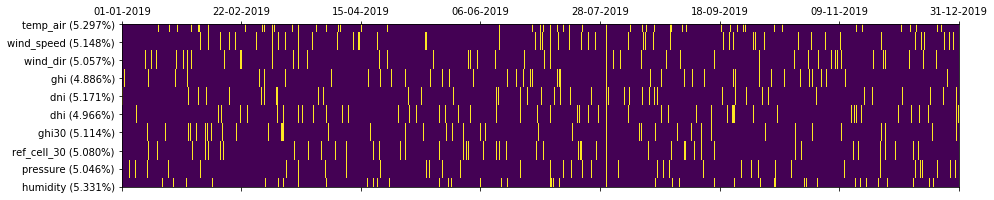

In [122]:
plot_missing(df_noisy)

We can define more interesting functions:

In [123]:
#export
def std_outliers(mean=0, std=1, std_coef=3):
    def _inner(df): return (np.abs(df-mean)>std_coef*std)
    return _inner

def diff_outliers(std=1, std_coef=2):
    def _inner(df): return (df.diff().abs()>std_coef*std)
    return _inner

def is_day(ghi_col='ghi'):
    def _inner(df): return df.loc[All, ghi_col]>0
    return _inner

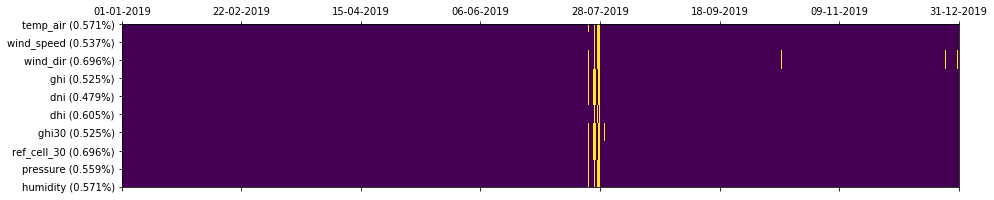

In [124]:
f_std = std_outliers(df.mean(), df.std())
plot_missing(df_noisy, f=f_std)

And the composition of various criteria

In [125]:
#export
def comp(l):
    def _inner(df): return reduce(operator.or_, [f(df) for f in l])
    return _inner

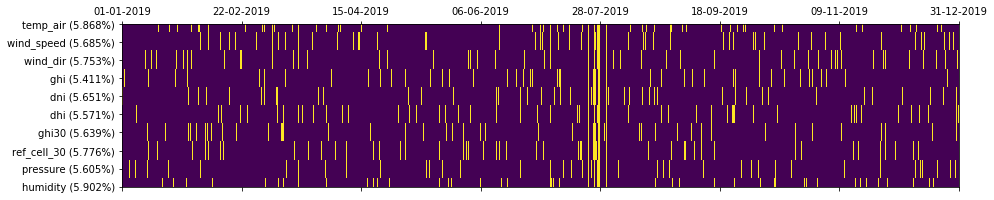

In [126]:
plot_missing(df_noisy, f = comp([pd.isna, f_std]))

In [127]:
#export
def view_anomaly(s: Series, f=std_outliers(0,1,3)):
    "Plots the missing/anomaly points"
    _, ax = plt.subplots(figsize=(14,6))
    a = f(s)
    ax.set_title(f' Anomaly rate: ({100*a.values.sum()/len(s):.3f}%)')
    ax.plot(s, color='blue', label = 'Normal')
    ax.scatter(a[a].index, s[a].fillna(0), color='red', label = 'Anomaly')
    ax.legend()
    return ax

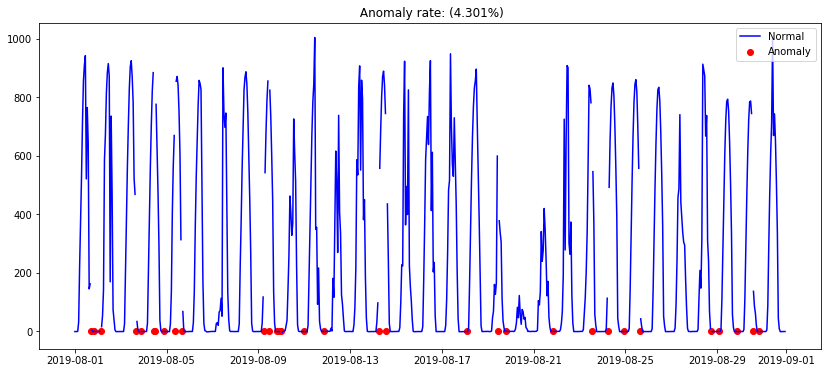

In [128]:
s = df_noisy.ghi['Aug 2019']
view_anomaly(s, f=comp([pd.isna, std_outliers(s.mean(), s.std())]))

## Filter Data

 Don't remember why I needed this

In [129]:
def percentile_cutoff(data, p_low=5, p_high=95):
    q_low = np.percentile(data,p_low)
    q_high = np.percentile(data, p_high)
    iqr = q_high - q_low
    cut_off = iqr * 1.25
    lower, upper = q_low - cut_off, q_high + cut_off
    return lower, upper

We will build a sklearn compatible `pipeline` to process our data. This will save us time later on

In [130]:
class MinMaxRemoval(TransformerMixin):
    "Remove values outside Min-Max within a given tolerance"
    def __init__(self, min_max_tol_dict):
        "A dictionary with the [min, max] interval and a tolerance"
        self.d = min_max_tol_dict
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        X = X.copy()
        for c, val in self.d.items():
            m, M, tol = val
            X[c] = (X[c].mask(np.abs(X[c] - m) < tol, m)  #min replace
                        .mask(np.abs(X[c] - M) < tol, M)  #max replace
                        .where((m - tol < X[c]) & (X[c] < M + tol))  #else replace by NaN
                   )
        return X

In [131]:
df.columns

Index(['temp_air', 'wind_speed', 'wind_dir', 'ghi', 'dni', 'dhi', 'ghi30',
       'ref_cell_30', 'pressure', 'humidity'],
      dtype='object')

In [132]:
d = {}
d['temp_air'] = (-20,50,1.0)
d['wind_speed'] = (0,30,0.1)
d['wind_dir'] = (0,360,5.0)
d['ghi'] = (0, 1300,10.0)
d['dni'] = (0, 1300,10.0)
d['dhi'] = (0, 1300,10.0)
d['pressure'] = (900, 1100,1.0)
d['humidity'] = (0,100,1.0)

You need to define the Transoform

In [133]:
mmr = MinMaxRemoval(d)

and actually apply to your data

In [134]:
mm_df = mmr.transform(df)

# Exports -

In [135]:
#hide
from nbdev.export import notebook2script
notebook2script()

Converted 00_utils.core.ipynb.
Converted 01_utils.pandas_hacks.ipynb.
Converted 03_utils.matlab_io.ipynb.
Converted 04_utils.missing.ipynb.
Converted 05_utils.plot.ipynb.
Converted index.ipynb.
